# Create interactive graph for results

Import relevant modules

In [113]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

Import the relevant files needed for this, we will be plotting based upo age and upon EU referendum results for the constituency

In [114]:
df_age = pd.read_csv(r"C:\Users\Josh\GitHub\election-data-analysis-2019-master\Age_by_year_data.csv")
df_res = pd.read_csv(r"C:\Users\Josh\GitHub\election-data-analysis-2019-master\constituency_results.csv")
df_EU = pd.read_csv(r"C:\Users\Josh\GitHub\election-data-analysis-2019-master\eureferendum_constituency.csv")

In [115]:
df_age.head(5)

,PCON11CD,RegionID,RegionNM,All Ages,Age_year,Age_pop,Age_percent,Reg_percent,UK_percent
0,E14000530,E15000008,South East,105601,0,1419,0.013437,0.010786,0.011218
1,E14000530,E15000008,South East,105601,1,1341,0.012699,0.011216,0.011599
2,E14000530,E15000008,South East,105601,2,1429,0.013532,0.011750,0.011986
3,E14000530,E15000008,South East,105601,3,1478,0.013996,0.011928,0.011999
4,E14000530,E15000008,South East,105601,4,1344,0.012727,0.012046,0.012112


In [116]:
df_res.head(5)

,ons,win,last_win,change
0,W07000049,LAB,LAB,LAB HOLD
1,W07000058,CON,CON,CON HOLD
2,S14000001,SNP,SNP,SNP HOLD
3,S14000002,SNP,CON,SNP GAIN FROM CON
4,S14000058,CON,CON,CON HOLD


In [117]:
df_EU.head(5)

,ons_code,constituency_name,estimate,known,known_leave,leave_to_use
0,E14000582,Boston and Skegness,75.60%,No,0.00%,75.60%
1,E14001011,Walsall North,71.20%,Yes,74.20%,74.20%
2,E14000642,Clacton,73.00%,No,0.00%,73.00%
3,E14000933,South Basildon and East Thurrock,73.00%,No,0.00%,73.00%
4,E14000771,Kingston upon Hull East,72.80%,No,0.00%,72.80%


Important to make some notes about these data frames and the corresponding data. Age and EU taken from 'House of Commons Library' and the results CSV taken from data publically availabe via BBC. 

Headers defined:
- PCON11CD/ons/ons_code: Ordnance survey constituency id
- leave_to_use: Leave vote as % of total vote (data is not known for all constituencies so this is an estimate)
- Age_year: Year of age 
- Age_precent : % of people in that constituency with that age

Define our required age range i.e. children can't vote and very little data for over 50

In [118]:
age_start = 18
age_end = 50

df_age_range = df_age.query(str(age_start) + '<= Age_year <=' + str(age_end)).groupby('PCON11CD')[['Age_percent']].sum()

Join the EU df with the election result df

In [119]:
df_res_EU = df_EU.join(df_res.set_index(['ons']), on=['ons_code'], how='inner')

In [120]:
df_res_EU.head(5)

,ons_code,constituency_name,estimate,known,known_leave,leave_to_use,win,last_win,change
0,E14000582,Boston and Skegness,75.60%,No,0.00%,75.60%,CON,CON,CON HOLD
1,E14001011,Walsall North,71.20%,Yes,74.20%,74.20%,CON,CON,CON HOLD
2,E14000642,Clacton,73.00%,No,0.00%,73.00%,CON,CON,CON HOLD
3,E14000933,South Basildon and East Thurrock,73.00%,No,0.00%,73.00%,CON,CON,CON HOLD
4,E14000771,Kingston upon Hull East,72.80%,No,0.00%,72.80%,LAB,LAB,LAB HOLD


Join this with the age data 

In [121]:
df_res_EU_age = df_age_range.join(df_res_EU.set_index(['ons_code']), on=['PCON11CD'], how='inner')

In [122]:
df_res_EU_age.head(5)

,Age_percent,constituency_name,estimate,known,known_leave,leave_to_use,win,last_win,change
PCON11CD,,,,,,,,,
E14000530,0.459721,Aldershot,58.10%,Yes,57.90%,57.90%,CON,CON,CON HOLD
E14000531,0.376826,Aldridge-Brownhills,68.70%,Yes,67.80%,67.80%,CON,CON,CON HOLD
E14000532,0.395912,Altrincham and Sale West,38.60%,No,0.00%,38.60%,CON,CON,CON HOLD
E14000533,0.398047,Amber Valley,65.30%,No,0.00%,65.30%,CON,CON,CON HOLD
E14000534,0.321523,Arundel and South Downs,49.70%,No,0.00%,49.70%,CON,CON,CON HOLD


replace WIN with HOLD, stops conusion in the data

In [123]:
df_res_EU_age['headline'] = df_res_EU_age['change'].apply(lambda x: ' '.join(x.split()[:2])).str.replace('WIN', 'HOLD')

Convert the percentages to decimals and remove % sign so they can be treated as floats not strings

In [124]:
df_res_EU_age['leave_to_use'] = df_res_EU_age['leave_to_use'].str.rstrip('%').astype('float')/100.0

Round percentages for easier mapping

In [125]:
decimals = 4
df_tot = df_res_EU_age
df_tot['leave_to_use'] = df_tot['leave_to_use'].apply(lambda x: round(x, decimals))
df_tot['Age_percent'] = df_tot['Age_percent'].apply(lambda x: round(x, decimals))

Graph the data, start by making colour dictionary for the parties and the seat gains

In [126]:
colour_dict = dict({'CON HOLD':'b',
                  'CON GAIN':'aqua',
                  'LAB HOLD': 'red',
                  'LAB GAIN': 'violet',
                  'GRN HOLD': 'g',
                  'DUP HOLD': 'sandybrown',
                  'LD HOLD': 'yellow',
                  'LD GAIN': 'orange',
                  'SNP HOLD': 'black',
                  'SNP GAIN': 'gray',
                  'PC HOLD': 'pink',
                  'SF HOLD': 'peru',
                  'SF GAIN': 'wheat',
                  'SDLP HOLD': 'salmon',
                  'SDLP GAIN': 'lightsalmon',
                  'APNI GAIN': 'lawngreen',
                  'SPE HOLD': 'navy'})

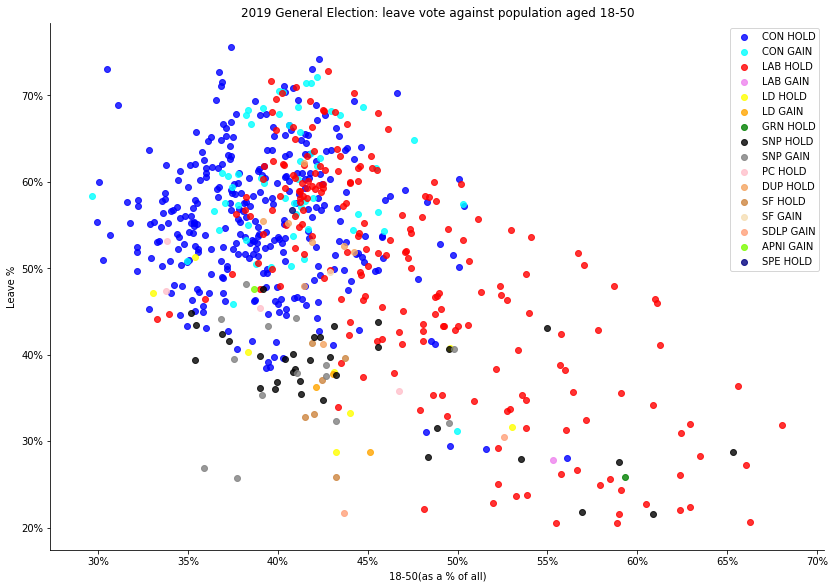

In [127]:
sns.lmplot(y="leave_to_use", x="Age_percent", data=df_tot, hue="headline", height=8.27, aspect=11.7/8.27, fit_reg=False, palette=colour_dict, legend=False)

plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()]) 
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

plt.ylabel("Leave %")
age_range = str(age_start) + "-" + str(age_end)
plt.xlabel(age_range + "(as a % of all)")

plt.title("2019 General Election: leave vote against population aged " + age_range, fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
# order legend 
order = [0,1,2,6,3,7,4,13,14,15,8,11,9,10,12,5]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.tight_layout()
plt.show()

From the produced data map above it can be seen that constituencied with older populations (smaller percentage in our range), not only were more likely to vote conservative but more likely to vote leave as well. There is a clear corelation between age and leave vote percentage. The younger constituencies (higher percentage along x) had a much lower leave vote and were moe likely to vote remain. Another key element is the clear conservative gains that occured in constituencies with high leave votes. There were almost no gains in areas where the vote was roughly 50:50 or favoured remain. With the biggest gains in constituencies with leave votes of over 60%. Other details like the fact that SNP seats are all in constituencies with <50% leave vote with the majority around  35-40%